# ノート 8: U-Network

### 目標: U-Network モデルを構築して学習させましょう

### 背景

最後に挑戦するニューラルネットワークモデルは U-Network（U-Net） と呼ばれるモデルです。
U-Net は畳み込みニューラルネットワークの一種ですが、「ダウン」ブランチと「アップ」ブランチがあり
ネットワークの構造を図にしたときに「U」の形になることから U-Net と呼ばれます。
ダウンブランチ（エンコーディング）では入力データの畳み込みと最大値プーリングを行い解像度を小さくしていきます。
逆に、アップブランチ（デコード）ではアンサンプリング（補間や転置畳み込みが使われます）により解像度が大きくなるように戻していきます（通常は入力された元の解像度に戻します）。

通常の CNN ではなく U-Net を使う利点は何でしょうか？

U-Net の一番の長所は画像から画像への変換ができることです。
つまり、U-Net は入力された画像と同じ形状の画像を出力するモデルです。
これまで扱ってきた衛星画像から雷を予測する問題設定に当てはめると、
U-Net を使うことで画像に雷が含まれるかどうかだけではなく発雷の位置も予測できるのです。


### Step 1: インポート


In [1]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # 不要な警告の抑止

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


print(f"NumPy  : {np.__version__}")
print(f"Pandas : {pd.__version__}")
print(f"Xarray : {xr.__version__}")
print(f"PyTorch: {torch.__version__}")

# jupyterのカスタマイズ
%config InlineBackend.figure_format = 'retina'

NumPy  : 1.26.3
Pandas : 2.2.0
Xarray : 2024.1.1
PyTorch: 2.1.2+cpu


### Step 2: データの読み込み


In [2]:
save_dir = Path("../datasets/sub-sevir")
ds_train = xr.open_dataset(save_dir / "sub-sevir-train.zarr", engine="zarr")
ds_valid = xr.open_dataset(save_dir / "sub-sevir-val.zarr", engine="zarr")

### Step 3: Dataset と DataLoader の作成

PyTorch の`Dataset` と `DataLoader` を作成します。
これまでのノートとの違いは `2d` と名前が付いたラベルを使うことです。


In [3]:
from torch.utils.data import TensorDataset, DataLoader

# データセットの作成
# PyTorch ではテンソルの次元が (B, C, H, W) なのでデータの特徴量次元を入れ替えておく
train_ds = TensorDataset(
    torch.FloatTensor(ds_train.features.values.transpose(0, 3, 1, 2)),
    torch.FloatTensor(ds_train.label_2d_class.values),
)
valid_ds = TensorDataset(
    torch.FloatTensor(ds_valid.features.values.transpose(0, 3, 1, 2)),
    torch.FloatTensor(ds_valid.label_2d_class.values),
)

`DataLoader` を作成する関数も定義しておきましょう。


In [4]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(
            train_ds, batch_size=bs, shuffle=True
        ),  # 訓練データのみシャッフルする
        DataLoader(valid_ds, batch_size=bs),
    )

バッチを取り出してデータを可視化してみます。


In [5]:
_ = torch.manual_seed(32)  # 取り出すバッチの再現性のため乱数の固定

batch_size = 64
train_dl, _ = get_data(train_ds, valid_ds, batch_size)
batch = next(iter(train_dl))

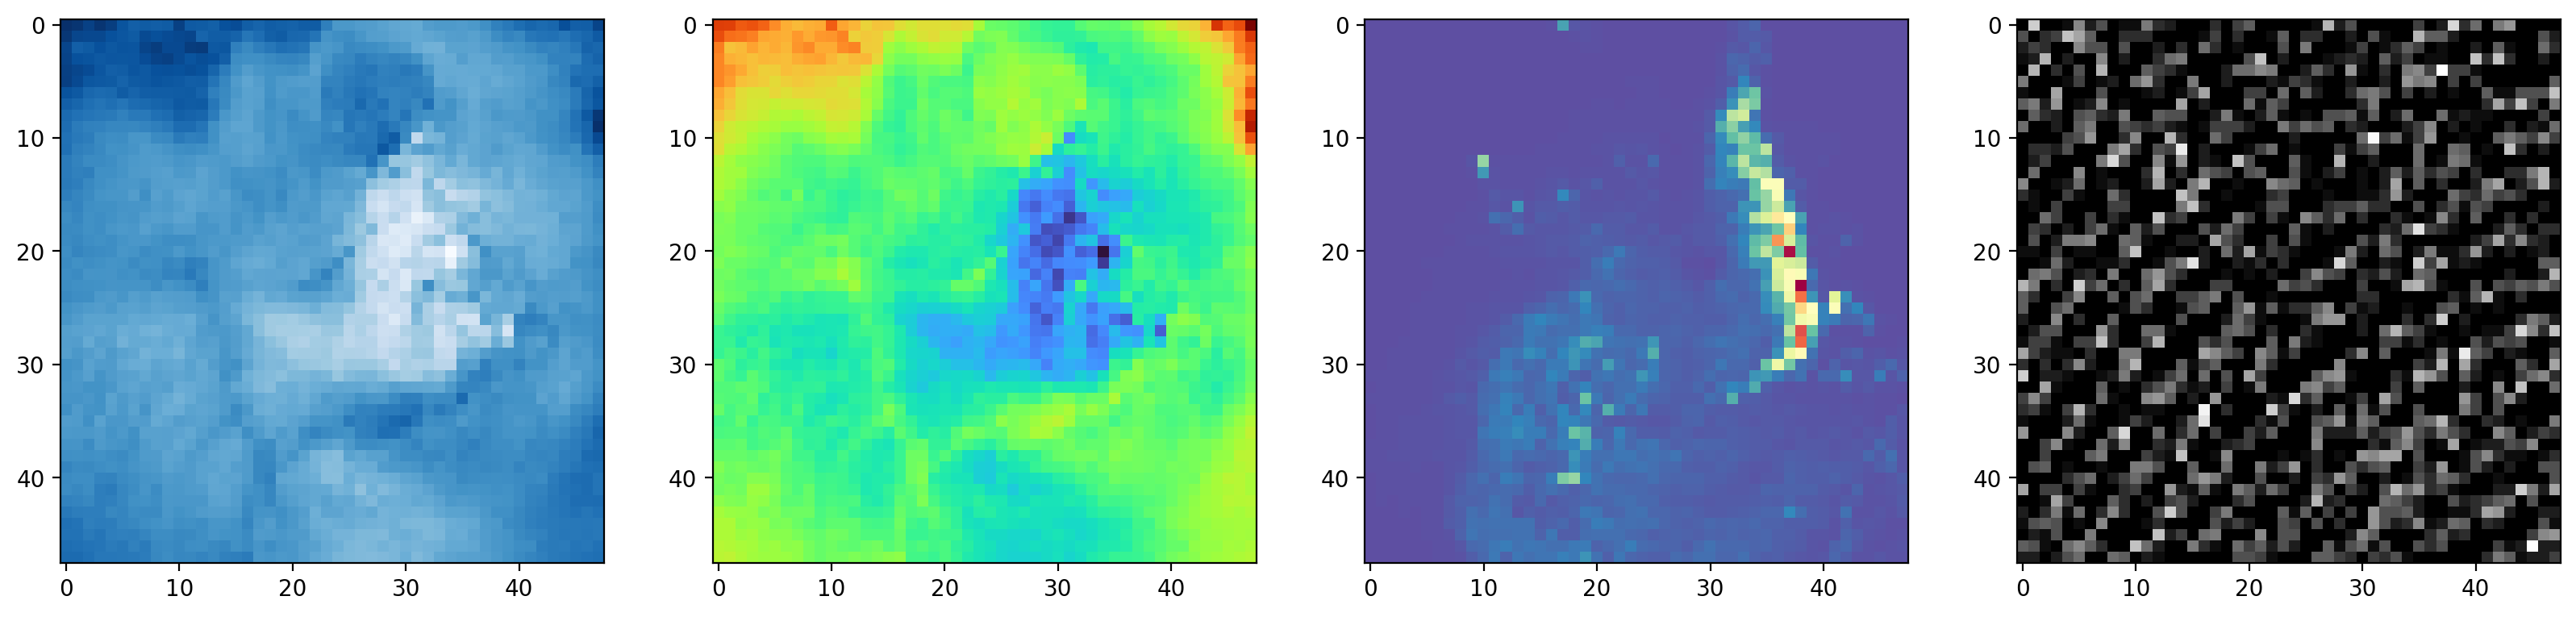

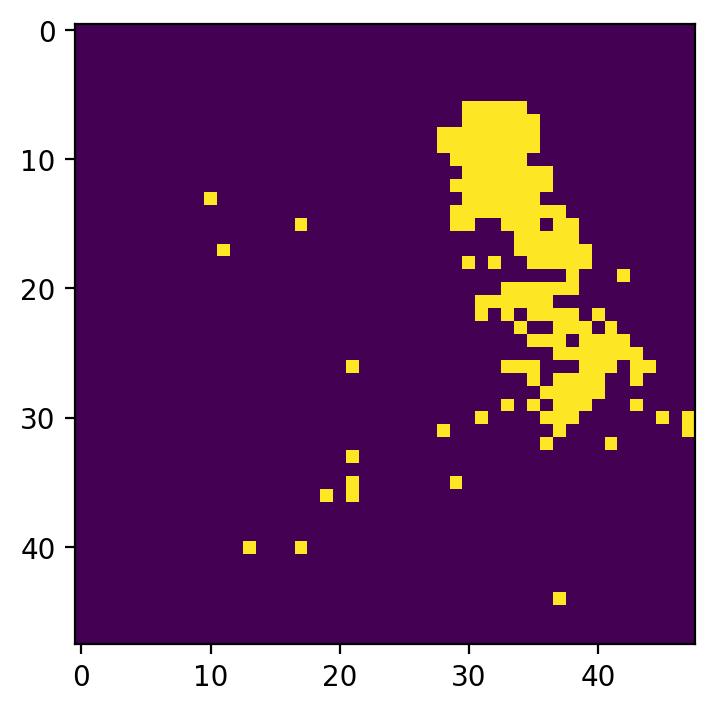

In [6]:
n = 27  # 先頭のバッチの28番目を可視化
one_example_features = batch[0][n]
one_example_label = batch[1][n]

# 画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.imshow(one_example_label)

1 つ目の画像は入力する特徴量で水蒸気画像、赤外線画像、レーダー（VIL）、可視画像です。
2 つ目の画像は雷の位置を表したラベルです。このラベルは雷がない場所を 0（紫）、雷がある場所を 1（黄）としています。U-Net の目的は各ピクセルでの雷の発生確率を含む特徴マップを作成することです。


### Step 4: モデルの構築

ダウンサンプリング、アップサンプリングを 1 つずつ持つ簡単な U-Net を PyTorch で構築します。

<image src="../images/unet_architecture.png" />

見通しをよくするために各層を`nn.Module` のサブクラスとして先に定義して、
このサブクラスを組み合わせて `UNet` クラスのモデルを構築します。

- `ConvBlock` : 畳み込み層。図の黒矢印（青枠部分を除く）の部分。
- `Down` : ダウンサンプリング層。図の赤矢印の部分。
- `Up` : UpConvolution 層。図の青枠部分。
- `Out` : 出力層。図の灰色矢印部分。

#### （注）カーネルの初期化と正則化

元論文のチュートリアルは Tensorflow/Keras の U-Net ライブラリを使用しています。
このノートでは PyTorch を使用してモデルを構築・学習させますが
元論文のモデルの設定を再現するために以下の実装を追加しています。

- 畳み込み層の重みパラメータを Glorot initialization（Glorot and Bengio, 2010）で初期化する
- バイアスパラメータをゼロで初期化する
- 重みパラメータ（バイアスは除く）による L1L2 正則化を各バッチで適用する

このノートの目的は U-Net を理解することなので詳しい説明は省略します。


In [7]:
class ConvBlock(nn.Module):
    """畳み込み層"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding="same")
        self.rl = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.rl(x)
        return x


class Down(nn.Module):
    """DownSampling層"""

    def __init__(self, kernel_size=2):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size)

    def forward(self, x):
        x = self.pool(x)
        return x


class Up(nn.Module):
    """UpConvolution層"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        # Keras の UpSampling2D に合わせるため align_corners=True とする
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding="same")
        self.rl = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        x = self.rl(x)
        return x


class Out(nn.Module):
    """出力層"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding="same")
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)
        return x


class UNet2D(nn.Module):
    """U-Netモデル"""

    def __init__(self):
        super().__init__()
        self.cb1 = ConvBlock(4, 2)
        self.down = Down()
        self.cb2 = ConvBlock(2, 4)
        self.up = Up(4, 2)
        self.cb3 = ConvBlock(4, 2)
        self.out = Out(2, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.cb1(x)
        x2 = self.down(x1)
        x2 = self.cb2(x2)
        x = self.up(x2)
        x = torch.concat([x, x1], dim=1)  # (B,C,H,W)をCに沿って結合
        x = self.cb3(x)
        x = self.out(x)
        return x

    def _init_weights(self) -> None:
        """
        モデルを構成する各層の重みを初期化する
        """
        # Kerasの初期化手法で重みとバイアスを初期化する
        for m in self.modules():
            if isinstance(
                m,
                (
                    nn.Linear,
                    nn.Conv1d,
                    nn.Conv2d,
                    nn.Conv3d,
                    nn.ConvTranspose1d,
                    nn.ConvTranspose2d,
                    nn.ConvTranspose3d,
                ),
            ):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias = nn.init.zeros_(m.bias)

    @torch.no_grad
    def get_wd_parameters(self):
        """
        畳み込み層の重みパラメータを返す。L1L2正則化のペナルティ計算に使用。
        """
        # このモデルのパラメータは畳み込み層の重みとバイアスのみ
        return [p for np, p in self.named_parameters() if np.endswith(".weight")]

`torchinfo` でモデルの構造を表示させてみます。


In [8]:
from torchinfo import summary

model = UNet2D()
summary(model, input_size=(batch_size, 4, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
UNet2D                                   [64, 1, 48, 48]           --
├─ConvBlock: 1-1                         [64, 2, 48, 48]           --
│    └─Conv2d: 2-1                       [64, 2, 48, 48]           74
│    └─ReLU: 2-2                         [64, 2, 48, 48]           --
├─Down: 1-2                              [64, 2, 24, 24]           --
│    └─MaxPool2d: 2-3                    [64, 2, 24, 24]           --
├─ConvBlock: 1-3                         [64, 4, 24, 24]           --
│    └─Conv2d: 2-4                       [64, 4, 24, 24]           76
│    └─ReLU: 2-5                         [64, 4, 24, 24]           --
├─Up: 1-4                                [64, 2, 48, 48]           --
│    └─Upsample: 2-6                     [64, 4, 48, 48]           --
│    └─Conv2d: 2-7                       [64, 2, 48, 48]           74
│    └─ReLU: 2-8                         [64, 2, 48, 48]           --
├─ConvBlock: 1-

### Step 5: 学習前のモデルの予測

学習前のモデルはカーネルの重みパラメータはランダムに初期化されています。
どのような予測になるか見てみましょう。


(0.0, 1.0)

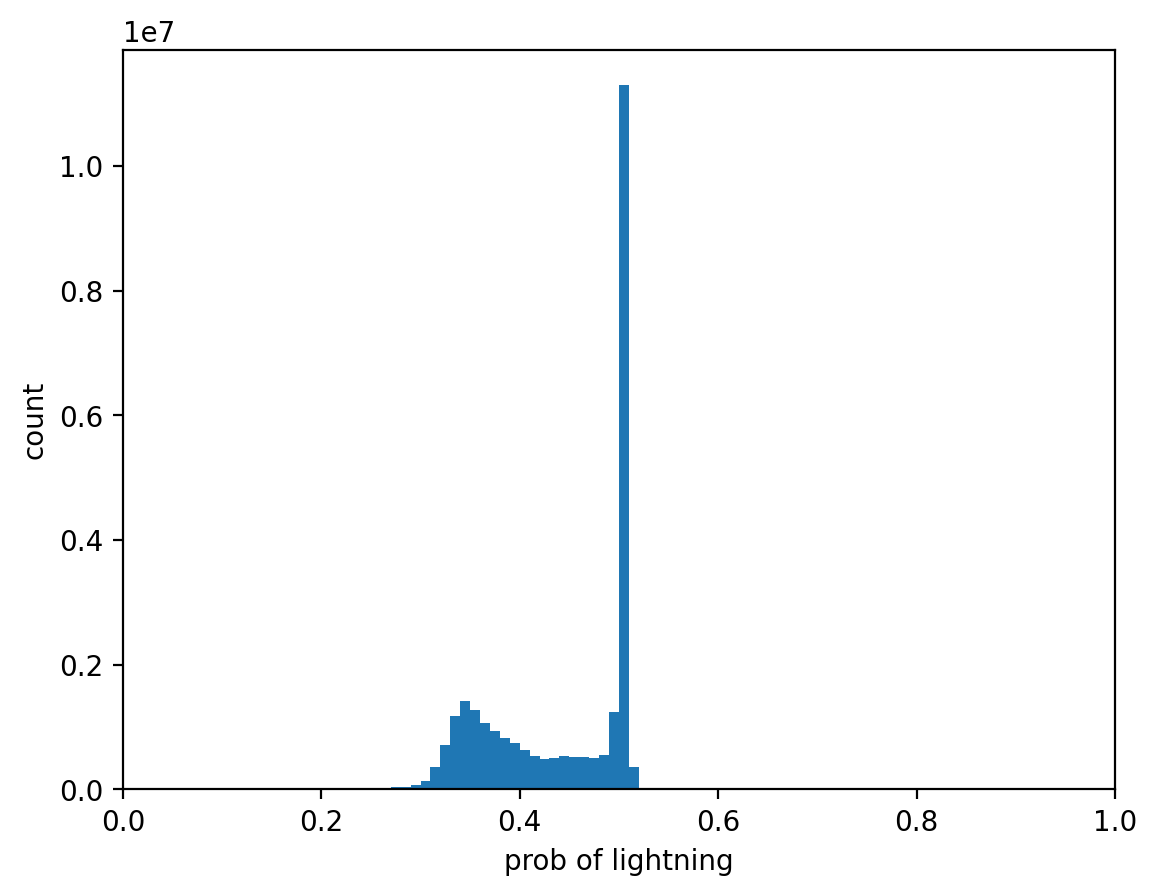

In [9]:
_ = torch.manual_seed(32)  # 取り出すバッチの再現性のため乱数の固定

batch_size = 64
_, valid_dl = get_data(train_ds, valid_ds, batch_size)

model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

plt.hist(y_preds.ravel(), bins=np.linspace(0, 1, 101, endpoint=True))
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

全サンプル（画像のピクセル）の予測の多くは 0.5 に近い値になりました。ランダムに初期化された重みであることを考えれば納得のいく結果です。
評価データから 1 例を取り出して予測を可視化してみます。


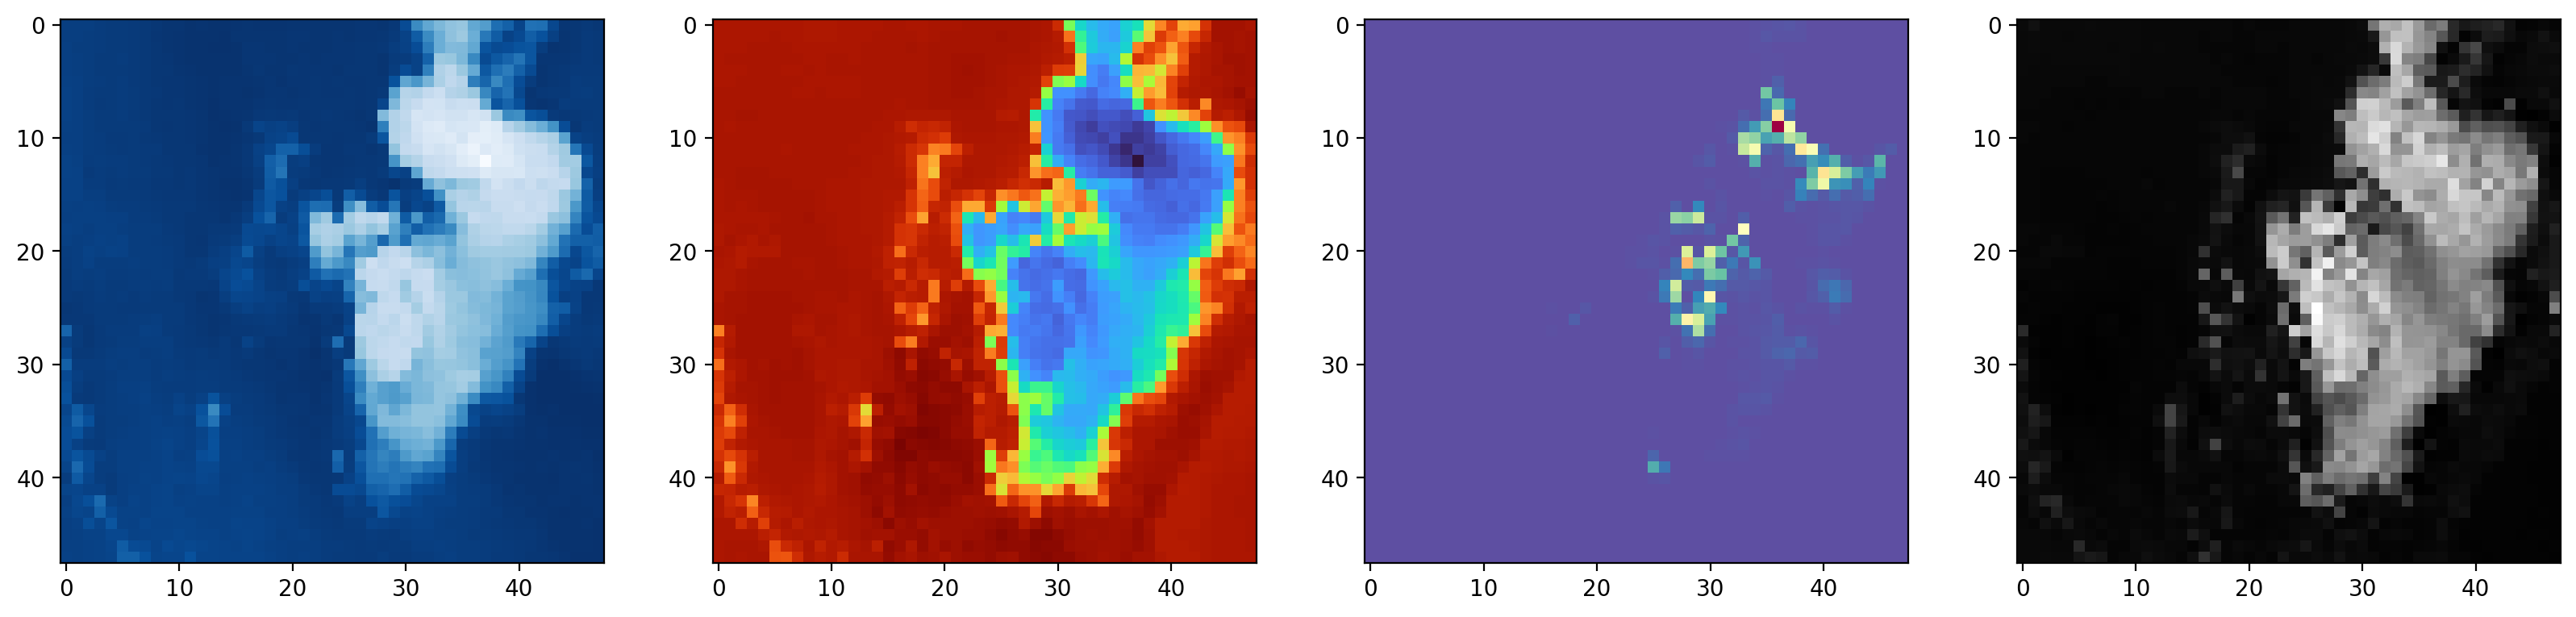

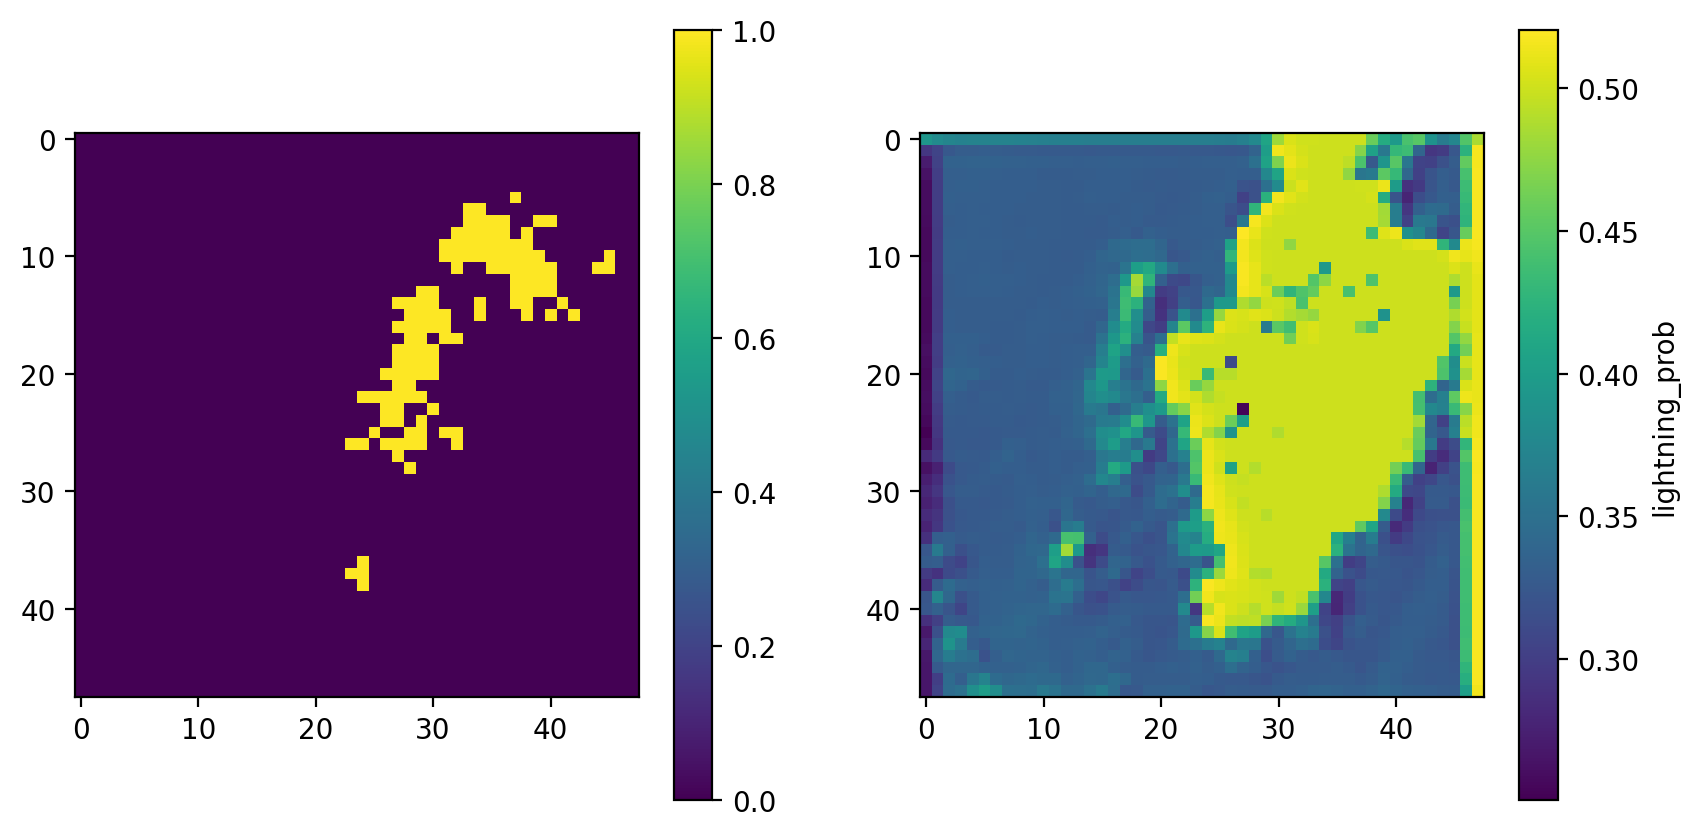

In [10]:
# 先頭のバッチを取り出す
with torch.no_grad():
    batch = next(iter(valid_dl))

one_example_features = batch[0][27]
one_example_label = batch[1][27]

# 画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm, ax=axes[0])
pm = axes[1].imshow(y_preds[27, 0, :, :])
plt.colorbar(pm, ax=axes[1], label="lightning_prob")

学習していないモデルが予測する雷の位置はランダムに推測したような分布になりました。


### Step 6: モデルの学習

計算に使うコンピューターの性能に依存しますが計算には 1 分程度時間がかかります。


In [11]:
from tqdm import tqdm


loss_fn = torch.nn.BCELoss()  # 損失関数には交差エントロピー誤差を使う
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # 最適化にはAdamを使う
l1 = 1e-2
l2 = 1e-2

train_losses = []
num_epoch = 5
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1}/{num_epoch}")

    # 学習
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_dl, total=len(train_dl)):
        pred = model(xb)
        loss = loss_fn(pred, yb.view(-1, 1, *yb.shape[1:]))

        # L1L2正則化
        l1_reg = sum([torch.norm(p, 1) for p in model.get_wd_parameters()])
        l2_reg = sum([torch.norm(p, 2) for p in model.get_wd_parameters()])
        loss += l1 * l1_reg + l2 * l2_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_dl)  # 1エポックの損失
    train_losses.append(train_loss)

Epoch 1/5


100%|██████████| 938/938 [00:17<00:00, 53.48it/s]


Epoch 2/5


100%|██████████| 938/938 [00:17<00:00, 53.04it/s]


Epoch 3/5


100%|██████████| 938/938 [00:17<00:00, 53.23it/s]


Epoch 4/5


100%|██████████| 938/938 [00:17<00:00, 53.23it/s]


Epoch 5/5


100%|██████████| 938/938 [00:16<00:00, 55.33it/s]


GPU が有効にできる環境であれば学習の計算はもっと早くなります。Google Colab 等を利用してチャレンジしてみましょう。


### Step 7: 学習済みモデルでの予測

学習済みモデルで評価データから予測してみましょう。


(0.0, 1.0)

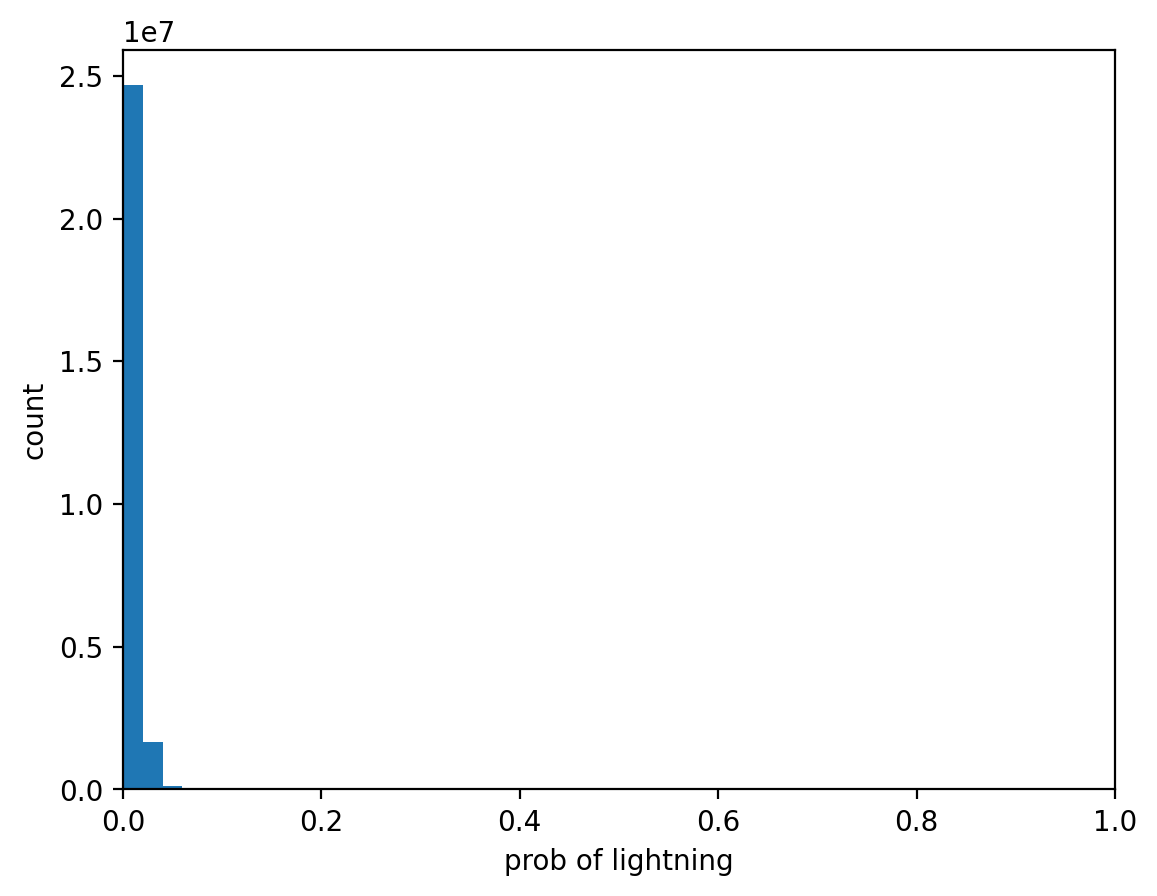

In [12]:
model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

plt.hist(y_preds.ravel(), bins=np.linspace(0, 1, 51, endpoint=True))
plt.xlabel("prob of lightning")
plt.ylabel("count")
plt.xlim([0, 1])

予測された発雷の確率の多くは 0 付近に分布しています。
これは全データセットの全ピクセルで見た場合には発雷が観測される格子は少ない（珍しいイベント）ため驚くような結果ではありません。
つまり、各サンプル画像につき数ピクセルのみで発雷が観測されているのが普通です。
Step 5 でプロットした事例と同じ事例をプロットして空間的な分布を確認してみましょう。


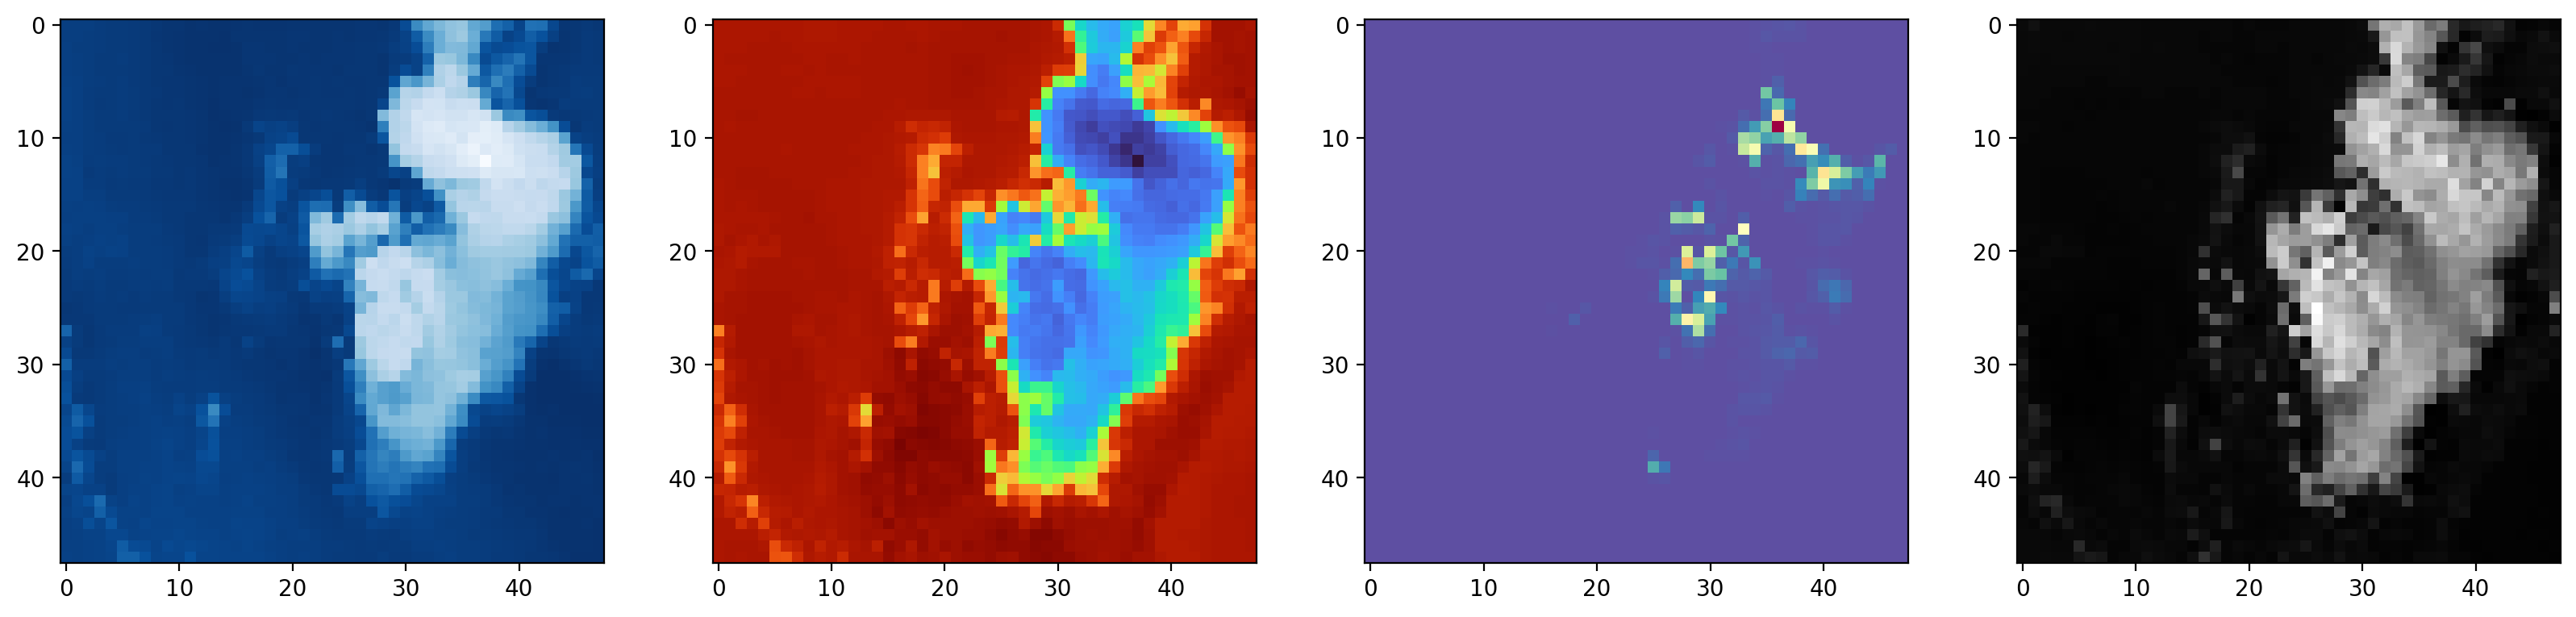

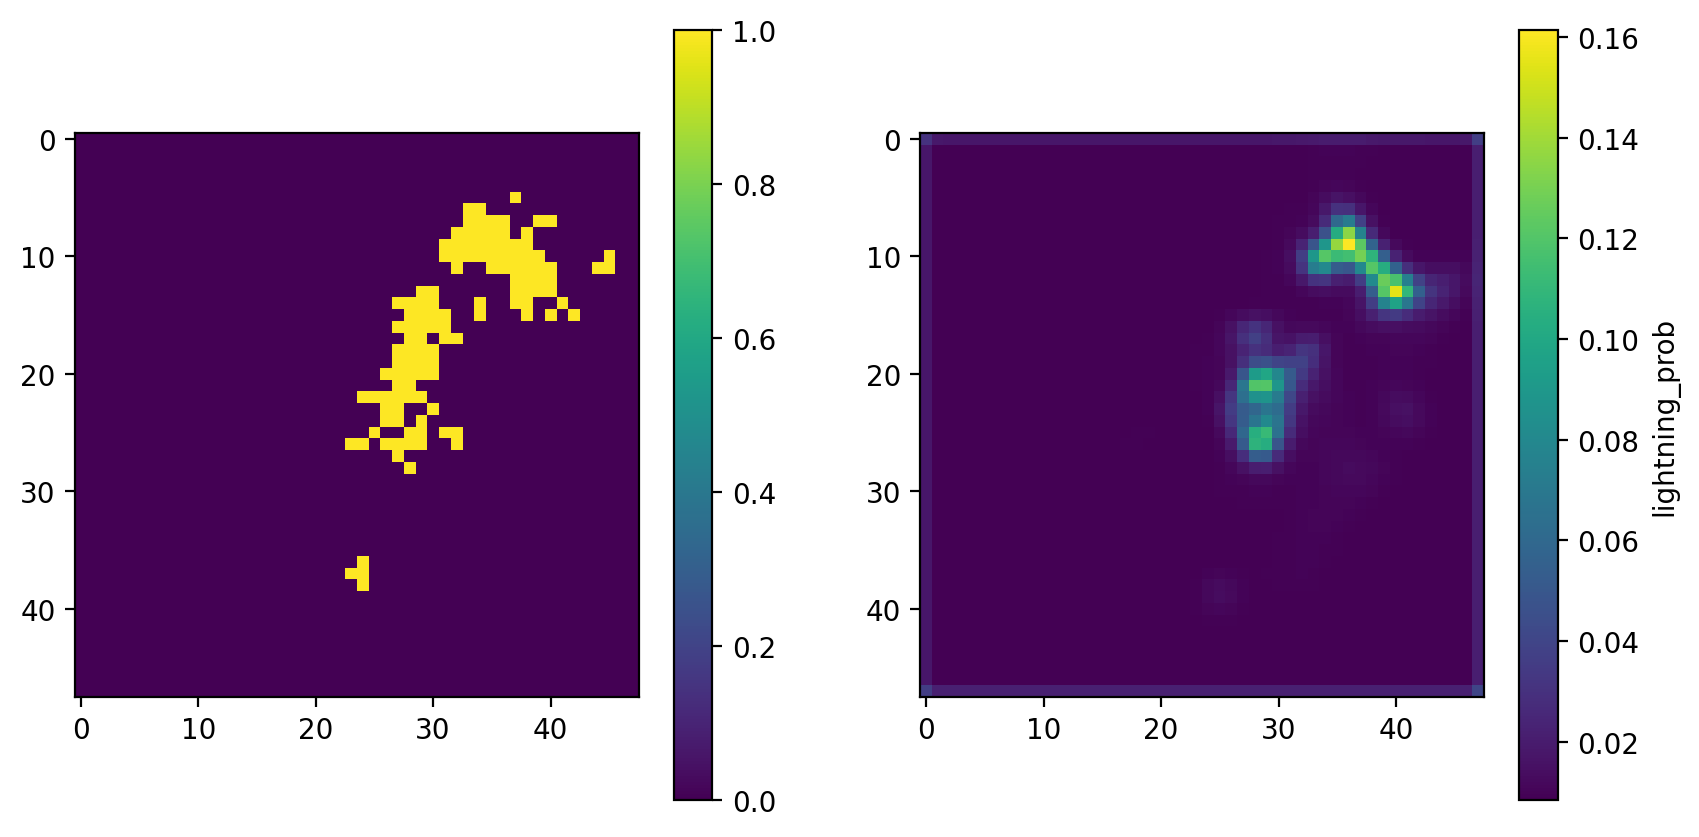

In [13]:
# 評価データの先頭バッチ
batch = next(iter(valid_dl))

# プロット
n = 27
one_example_features = batch[0][n]
one_example_label = batch[1][n]

# 画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pm = axes[0].imshow(one_example_label, vmin=0, vmax=1)
plt.colorbar(pm, ax=axes[0])
pm = axes[1].imshow(y_preds[n, 0, :, :])
plt.colorbar(pm, ax=axes[1], label="lightning_prob")

発雷している領域を概ね正しくとらえることができています。
予測された確率（の絶対値）は低い値になっていることに注目してください。
次のステップでこのような珍しい現象を評価するのに役に立つパフォーマンスダイアグラムを見てみましょう。
今回は 1 ピクセル毎に分析を行うので、これまでのノートよりサンプル数が大きく増えます。


### Step 7: 評価

パフォーマンスダイアグラムを描きます。


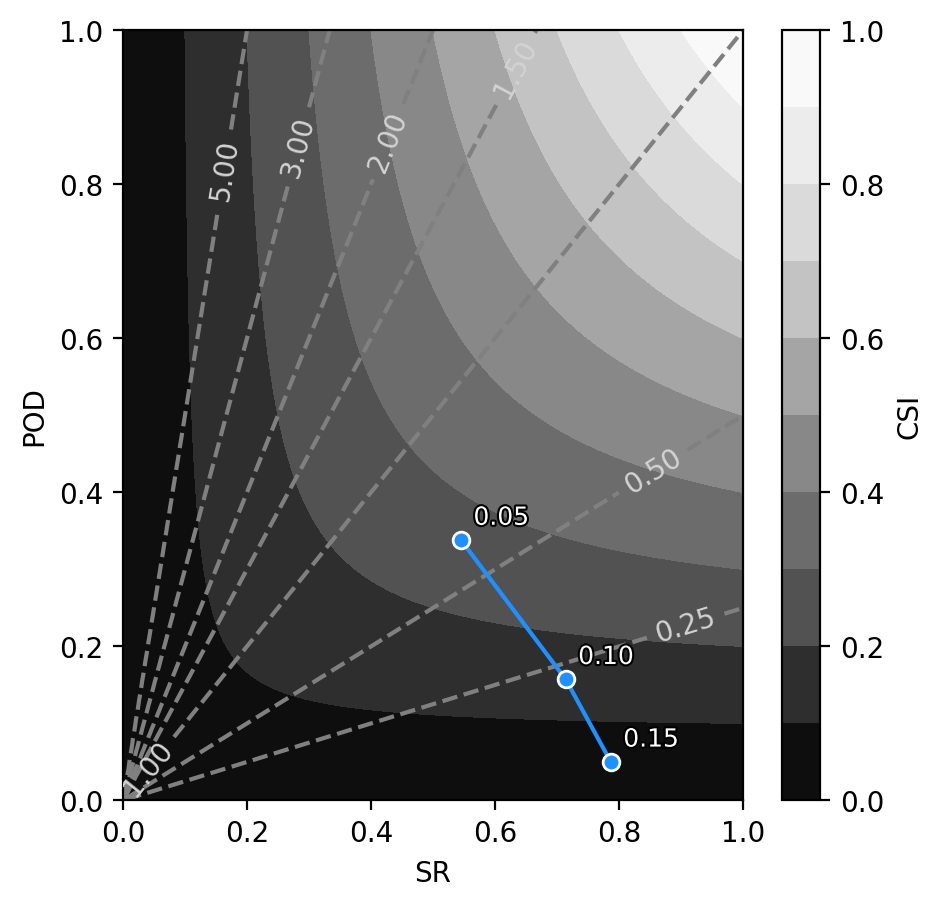

In [16]:
import matplotlib.patheffects as path_effects

# ユーティリティ関数の読み込み
import sys

sys.path.insert(1, "../scripts/")
from gewitter_functions import (
    get_contingency_table,
    get_pod,
    get_sr,
    make_performance_diagram_axis,
)


def plot_performance_diagram(y_preds, y_valid):
    # 確率の閾値
    thresholds = np.arange(0.05, 1.0, 0.05)

    pod_list = []
    sr_list = []
    # 閾値を変えながら指標を計算
    for t in thresholds:
        y_preds_bi = np.zeros(y_preds.shape, dtype=int)
        idx = np.where(y_preds >= t)
        y_preds_bi[idx] = 1

        # 検証データのラベル（真値）と予測値のラベルから分割表を作成
        cont_table = get_contingency_table(y_preds_bi, y_valid)
        pod_list.append(get_pod(cont_table))
        sr_list.append(get_sr(cont_table))

    ax = make_performance_diagram_axis()
    ax.plot(sr_list, pod_list, "o-", c="dodgerblue", mec="w")

    for i, (sr, pod, t) in enumerate(zip(sr_list, pod_list, thresholds)):
        if sr and pod:
            text = f"{np.round(t, 2):.2f}"
            ax.text(
                sr + 0.02,
                pod + 0.02,
                text,
                fontsize=9,
                c="white",
                path_effects=[path_effects.withStroke(linewidth=1.5, foreground="k")],
            )


y_preds = y_preds.ravel()  # 評価データからの予測を1次元にまとめる
y_valid = valid_ds.tensors[1].numpy().ravel()  # 評価データのラベルを1次元にまとめる
plot_performance_diagram(y_preds, y_valid)

全体的に見れば性能はそれほど高くないことが分かります。
しかし、限られたエポック数でしか U-Net モデルを訓練していないため、まだ完全な解に収束していない可能性があります。
また、このノートで扱っている分類問題はこれまでのノートで ANN や CNN を使って解いていた分類問題よりもはるかに難しいです。画像に発雷が含まれるかどうかだけでなく発雷がどこにあるかも知ろうとしています。
このため、期待されるモデルの性能を見直しておく必要があるかもしれません。


#### Step 8: バッチサイズを変えて学習させる

GPU を使わずに CPU で学習させた場合でも妥当な計算時間で「機能する」U-Net を見つける（バッチサイズ等のハイパーパラメータの調整）ためにはそれなりの時間が実はかかっています。
これを実証するためにミニバッチのバッチサイズを 64 ではなく 32 に下げてみましょう。バッチサイズを小さくしたので先ほどの学習より計算時間は長くなります。


In [17]:
from tqdm import tqdm

_ = torch.manual_seed(32)  # 取り出すバッチの再現性のため乱数の固定

batch_size = 32
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)

model = UNet2D()  # モデルの初期化

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

l1 = 1e-2
l2 = 1e-2

train_losses = []
num_epoch = 5
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1}/{num_epoch}")

    # 学習
    model.train()
    train_loss = 0
    for xb, yb in tqdm(train_dl, total=len(train_dl)):
        pred = model(xb)
        loss = loss_fn(pred, yb.view(-1, 1, *yb.shape[1:]))

        # L1L2正則化
        l1_reg = sum([torch.norm(p, 1) for p in model.get_wd_parameters()])
        l2_reg = sum([torch.norm(p, 2) for p in model.get_wd_parameters()])
        loss += l1 * l1_reg + l2 * l2_reg

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss = train_loss / len(train_dl)  # 1エポックの損失
    train_losses.append(train_loss)

Epoch 1/5


100%|██████████| 1875/1875 [00:23<00:00, 80.10it/s]


Epoch 2/5


100%|██████████| 1875/1875 [00:24<00:00, 76.35it/s]


Epoch 3/5


100%|██████████| 1875/1875 [00:24<00:00, 76.95it/s]


Epoch 4/5


100%|██████████| 1875/1875 [00:24<00:00, 76.56it/s]


Epoch 5/5


100%|██████████| 1875/1875 [00:24<00:00, 76.91it/s]


予測された確率のヒストグラムを見てみます。右側のプロットは左側の全体の分布を拡大したものです。


(0.0, 0.05)

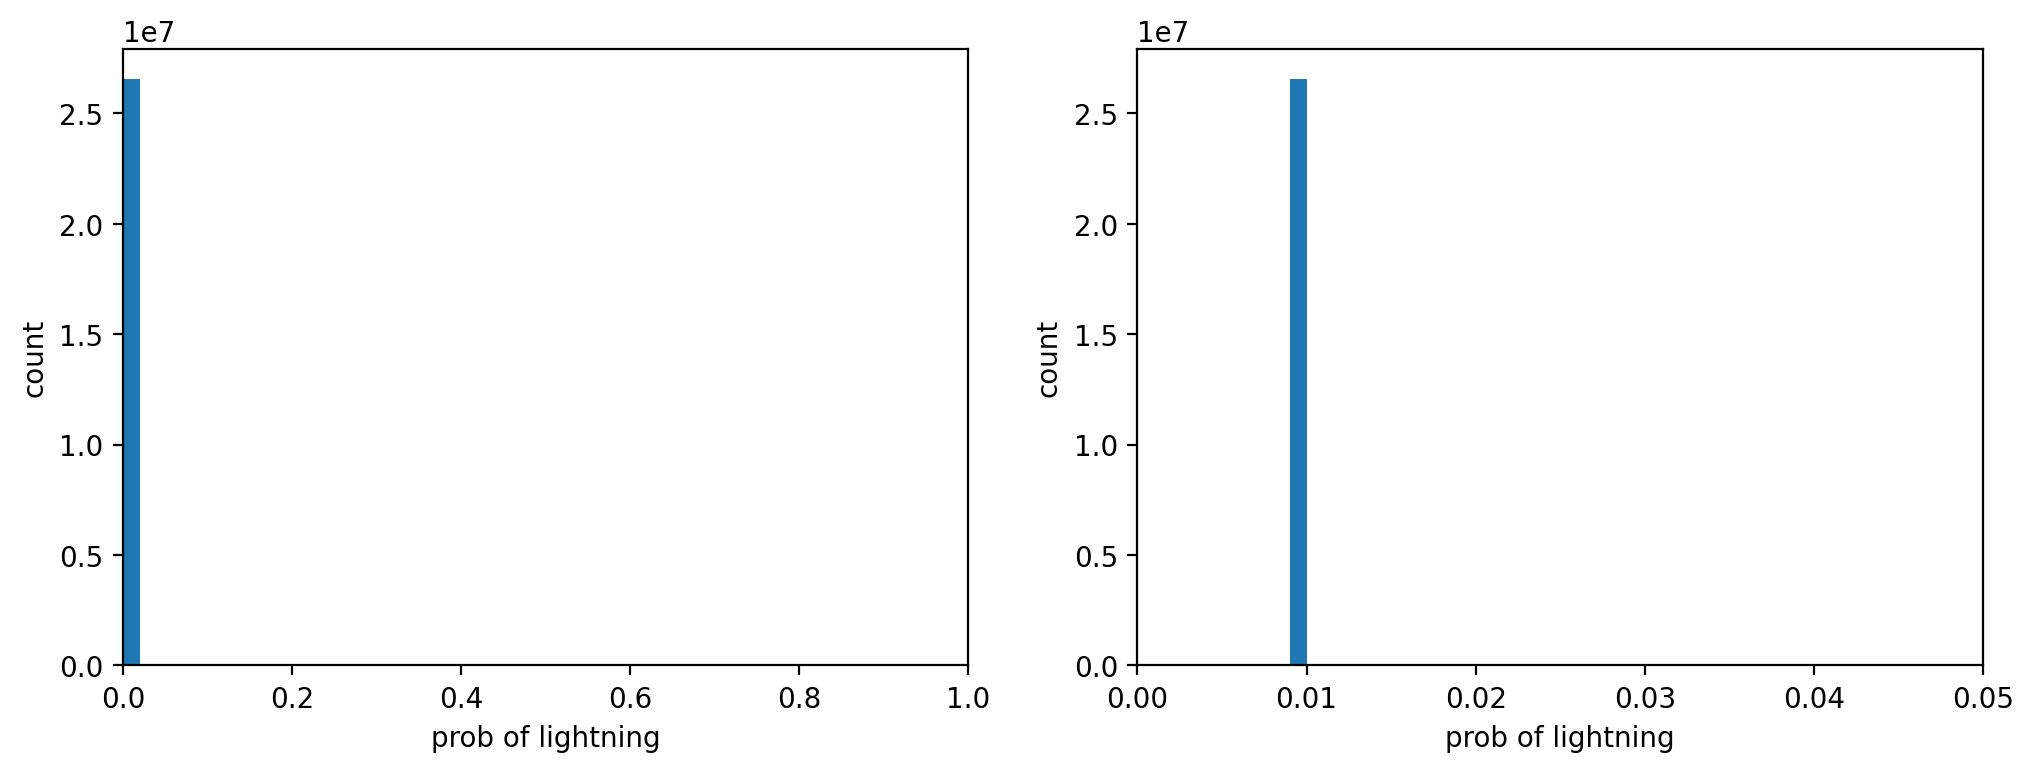

In [28]:
model.eval()
with torch.no_grad():
    y_preds = torch.cat([model(xb) for xb, _ in valid_dl]).numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(y_preds.ravel(), bins=np.linspace(0, 1, 51, endpoint=True))
axes[0].set_xlabel("prob of lightning")
axes[0].set_ylabel("count")
axes[0].set_xlim([0, 1])

axes[1].hist(y_preds.ravel(), bins=np.linspace(0, 0.05, 51, endpoint=True))
axes[1].set_xlabel("prob of lightning")
axes[1].set_ylabel("count")
axes[1].set_xlim([0, 0.05])

この図からも分かると思いますが、バッチサイズを小くしていくと予測結果に変化が生じました。モデルの予測はほとんど 1 つの値になっているように見えます。
1 事例を可視化してみるとよりはっきりと確認できると思います。


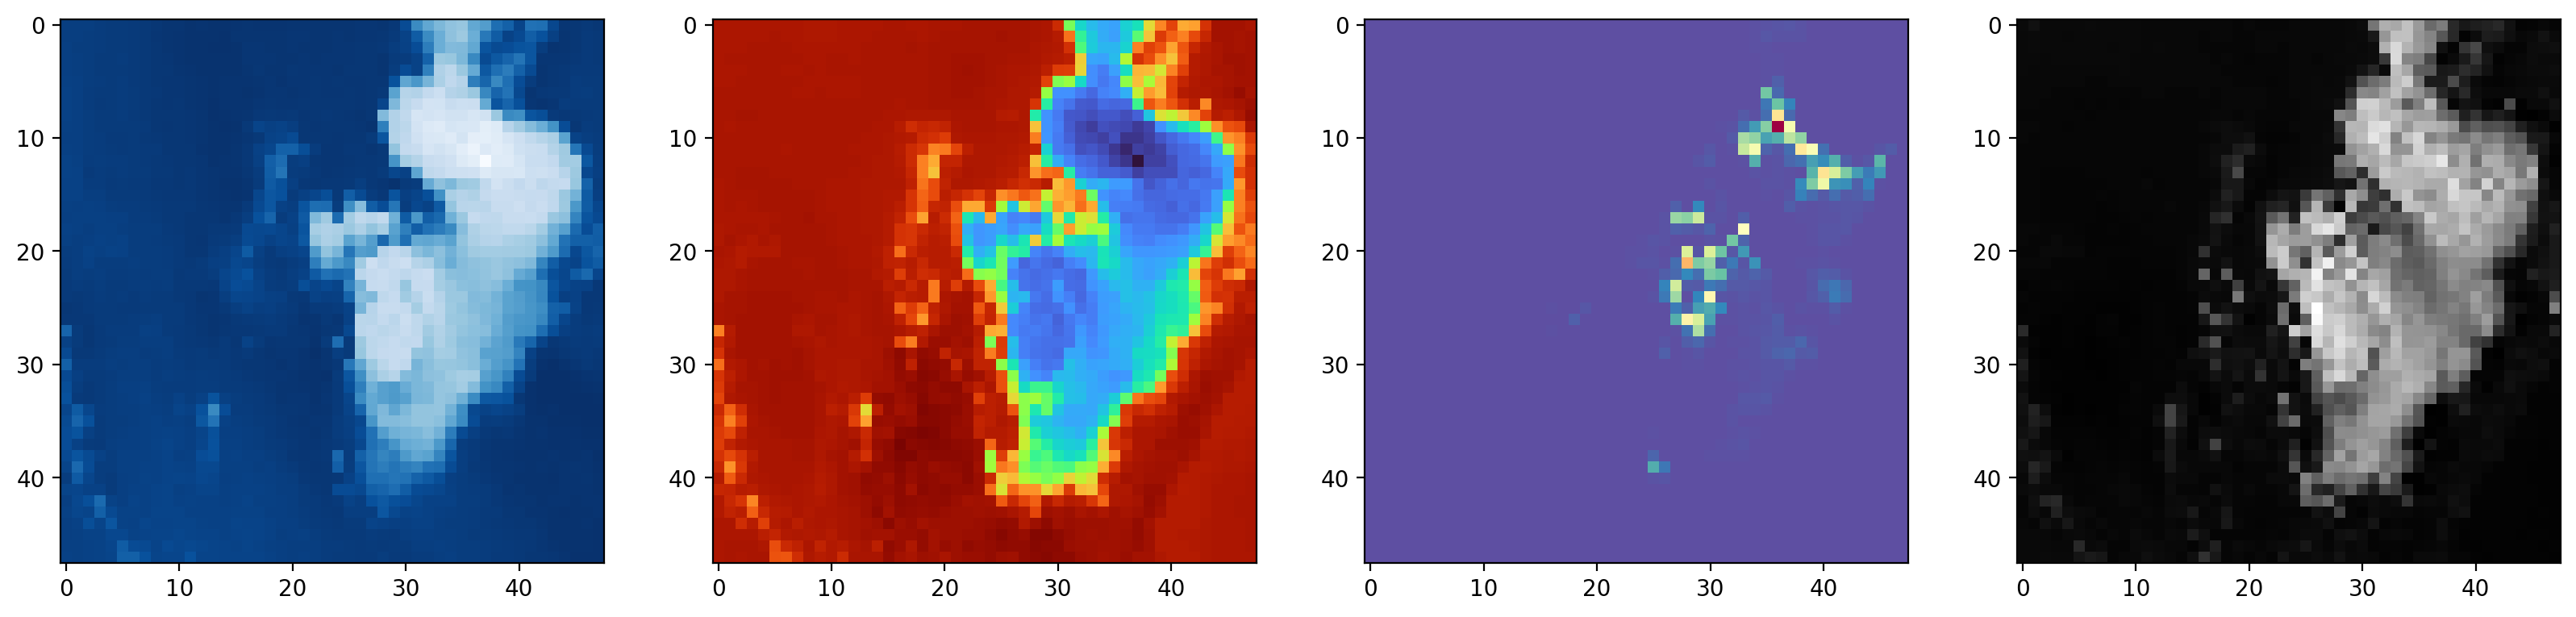

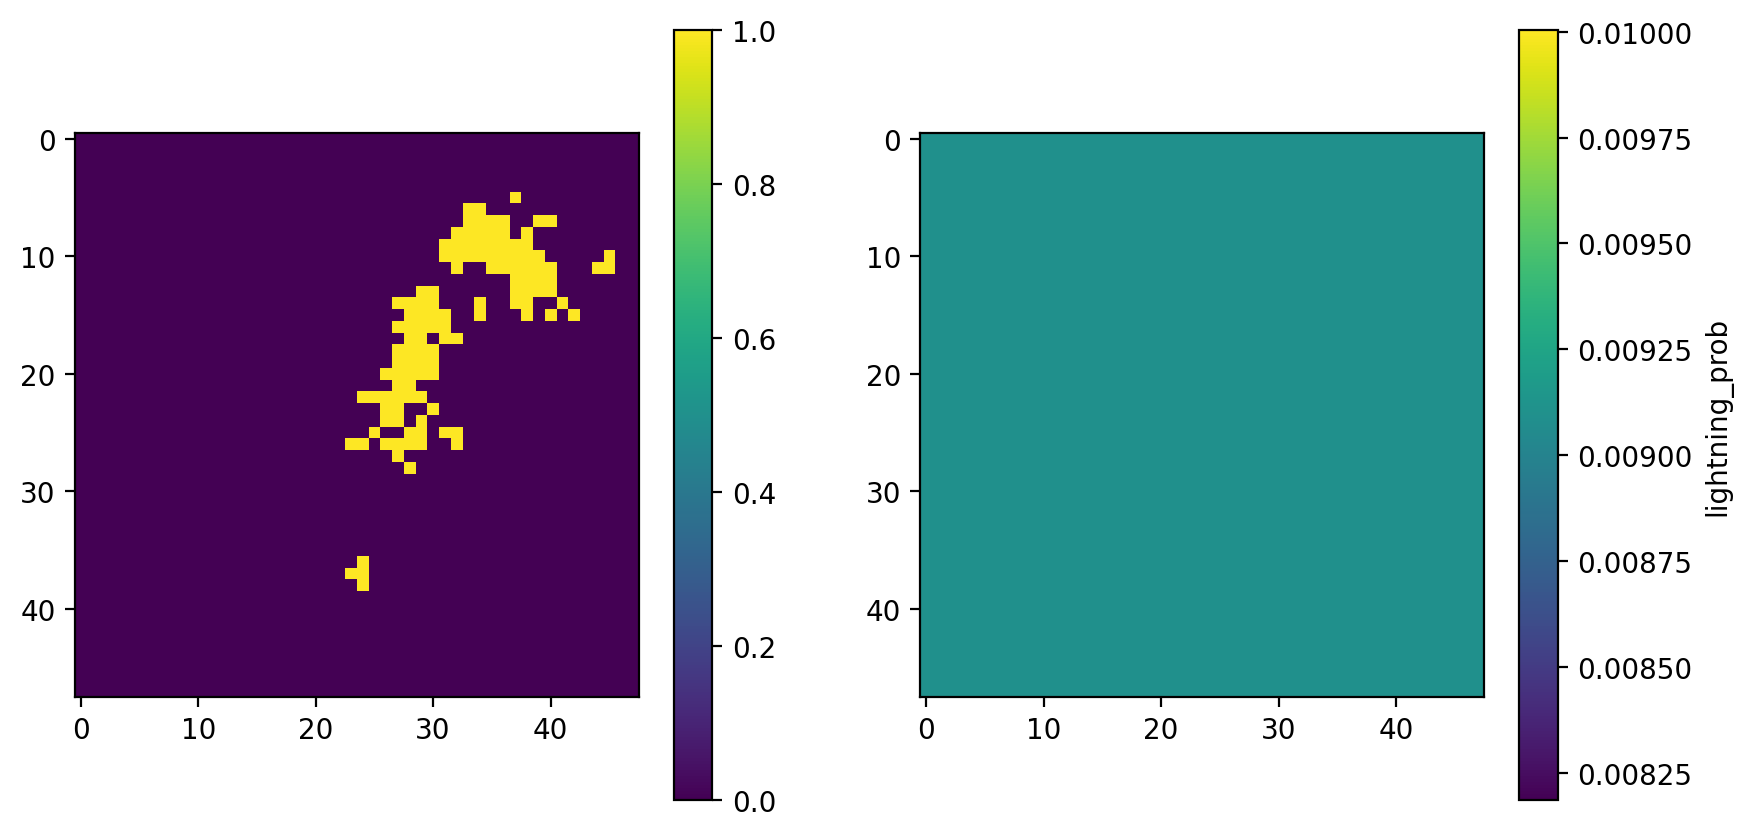

In [29]:
# 評価データの先頭バッチ
batch = next(iter(valid_dl))

# Step6と同じサンプルをプロット
n = 27
one_example_features = batch[0][n]
one_example_label = batch[1][n]

# 画像をプロット
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(one_example_features[0, :, :], cmap="Blues")
axes[1].imshow(one_example_features[1, :, :], cmap="turbo")
axes[2].imshow(one_example_features[2, :, :], cmap="Spectral_r")
axes[3].imshow(one_example_features[3, :, :], cmap="Greys_r")

# ラベルを表示
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
pm = axes[0].imshow(one_example_label)
plt.colorbar(pm, ax=axes[0])
pm = axes[1].imshow(y_preds[n, 0, :, :])
plt.colorbar(pm, ax=axes[1], label="lightning_prob")

ヒストグラムから予想されたとおり画像内のほぼすべてのピクセルで同じ値が予測されてしまっています。
なぜこのようなことが起こるのでしょうか？
おそらく、予測対象とした発雷は珍しいイベント（全サンプルに対して有りと分類されるサンプルがはるかに少ない）であるために
雷を全く予測しないように学習してしまったのでしょう。しかしこれは損失関数の最適化という観点で見れば適切に最適化の結果で間違いではありません。
では、バッチサイズを 64 に増やすとなぜこの問題が解決されるのでしょうか？

1 つはバッチサイズが大きいほど損失関数の計算に使うミニバッチに発雷を含むサンプルが多く含まれるようになるため、
損失関数の最適化で発雷有りという観測がより大きな影響を与えるというものです。
加えて、バッチサイズを 64 にすることで真の勾配をよりよく推定することができるようになり、
重みの予測と損失関数の値の改善につながるはずです。

こうした理論の説明はこのチュートリアルの範囲外の議論かもしれませんが、
ML モデルの学習は見かけほど簡単ではないことを示す好例です。時には上手く学習が進まず苛立ってしまうこともあるかもしれません。
